In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from pymbar import timeseries as ts

# Analysis of NCMC parameter exploration
## Using GHMC as propagator
For a fixed chemical potential, the number of perturbation and propagtion kernels were experimented with to observe the effects on the acceptance probability. 

### Contents
* <a href='#summary'>Summary of performance</a>: NCMC results at a quick glance
    - <a href='#summary_set1'>Parameter set 1</a>
    - <a href='#summary_set2'>Parameter set 2</a>
* <a href='#good_params'>Investigating optimal NCMC parameters</a>
    - <a href='#stat_ineff'>Statistical inefficiency</a>
    - <a href='#eff_samps'>Effective number of samples for a fixed run-time</a> Most useful in picking best protocol
    - <a href='#acc_prob'>Acceptance probability</a>

Defining a function to read the simulation data, and generating pretty colours for plotting.

In [2]:
def readdata(filename):
    filelines = open(filename).readlines()
    Nwats = []
    Nsalt = []
    Accprob = []
    time = []
    i=3
    step = int(filelines[i][0:5].strip())
    #while i-3 == step:
    #while i > 0:
    for i in range(3,len(filelines)-3):
        # It appears some of the files have a varying length. This exception will pick those up.
        try:
            dummy = int(filelines[i][6:10].strip())
        except ValueError:
            break
        Nwats.append(int(filelines[i][6:10].strip()))
        Nsalt.append(int(filelines[i][15:18].strip()))
        Accprob.append(float(filelines[i][19:24].strip()))
        time.append(int(filelines[i][24:30].strip()))
        #i += 1
    return np.vstack((np.array(Nwats),np.array(Nsalt),np.array(Accprob),np.array(time)))

# Nice colours, taken on 26th Nov 2015 from:
#http://tableaufriction.blogspot.co.uk/2012/11/finally-you-can-use-tableau-data-colors.html

# These are the "Tableau" colors as RGB. I've chosen my faves. 
# In order: blue, green, purple, orange. Hopefully a good compromise for colour-blind people.
tableau4 = [(31, 119, 180),(44, 160, 44),(148,103,189),(255, 127, 14)]
tableau4_light = [(174,199,232),(152,223,138),(197,176,213),(255,187,120)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts. 
for i in range(len(tableau4)):    
    r, g, b = tableau4[i]    
    tableau4[i] = (r / 255., g / 255., b / 255.)
    r, g, b = tableau4_light[i]    
    tableau4_light[i] = (r / 255., g / 255., b / 255.)

Reading in the data:

In [3]:
# Results from the initial set of parameters:
nperturbations = [126,512,1024,2048,4096]
npropogations = [1,2,4,8,16,32,64]

MeanSalt = np.zeros((len(nperturbations),len(npropogations)))
AccProb = np.zeros((len(nperturbations),len(npropogations)))
MeanTime = np.zeros((len(nperturbations),len(npropogations)))

for i in range(len(nperturbations)):
    for j in range(len(npropogations)):
        filename = 'NCMC_sweep_GHMC/nk{0}_nV{1}/run1.txt'.format(nperturbations[i],npropogations[j])
        data = readdata(filename)
        MeanSalt[i,j] = data[1].mean()     # The recorded times are for 10 insertion attempts 
        AccProb[i,j] = data[2].mean()
        MeanTime[i,j] = data[3].mean()/10
        
# Results from the second set of parameters, that were run after the results of the first set.
# The focus here was on increasing the number of propogation steps.
nperturbations2 = [512,1024]
npropogations2 = [126,256,512,1024]

MeanSalt2 = np.zeros((len(nperturbations2),len(npropogations2)))
AccProb2 = np.zeros((len(nperturbations2),len(npropogations2)))
MeanTime2 = np.zeros((len(nperturbations2),len(npropogations2)))

for i in range(len(nperturbations2)):
#for i in [0,1]:    
    for j in range(len(npropogations2)):
        filename = 'NCMC_sweep_GHMC/nk{0}_nV{1}/run1.txt'.format(nperturbations2[i],npropogations2[j])
        data = readdata(filename)
        MeanSalt2[i,j] = data[1].mean() # The recorded times are for 10 insertion attempts 
        AccProb2[i,j] = data[2].mean()
        MeanTime2[i,j] = data[3].mean()/10


<a id='summary'></a>
## NCMC parameter sweep at a glance
Plotting colored matrices to summarise the main results.

<a id='summary_set1'></a>
### Parameter set 1
Generated under initial indications that there an additional overhead when using `updateParametersinContext` makes it time efficient to increase the number of MD steps in the propagation kernal.

Acceptance rates around 12% 300s can be achieved with a protocol that takes around 300s per insertion. This is probably too long.

/Users/rossg/miniconda2/lib/python2.7/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


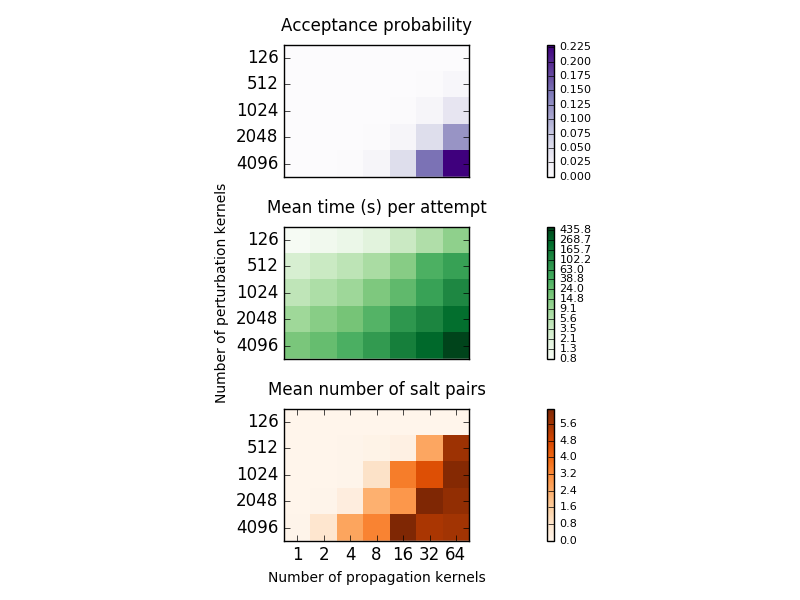

In [4]:
fig,ax = plt.subplots(nrows=3,ncols=1,squeeze=True)

# Acceptance probability
cax = ax[0].matshow(np.round(AccProb,2),cmap=plt.cm.Purples,interpolation='none')
c = fig.colorbar(cax,ax=ax[0])
c.ax.tick_params(labelsize=8) 
ax[0].get_xaxis().set_visible(False)
ax[0].set_yticklabels(['']+nperturbations)
ax[0].set_title('Acceptance probability',fontsize=12)

# Mean time per attempt on log scale
logtimes = np.log10(MeanTime)
lt = np.arange(np.min(logtimes),np.max(logtimes),0.21)
ticks = np.round(10**lt,1)
cax = ax[1].matshow(logtimes,cmap=plt.cm.Greens,interpolation='none')
c = fig.colorbar(cax,ticks=lt,ax=ax[1])
c.set_ticklabels(ticks, update_ticks=True)
c.ax.tick_params(labelsize=8) 
ax[1].set_xticklabels(['']+npropogations)
ax[1].get_xaxis().set_visible(False)
#ax[1].xaxis.set_tick_params(labelbottom='on',labeltop='off')
ax[1].set_yticklabels(['']+nperturbations)
ax[1].set_title('Mean time (s) per attempt',fontsize=12)
ax[1].set_ylabel("Number of perturbation kernels",fontsize=10)   

# Mean number of salt pairs to test consistency
cax = ax[2].matshow(MeanSalt,cmap=plt.cm.Oranges,interpolation='none')
c = fig.colorbar(cax)
c.ax.tick_params(labelsize=8) 
ax[2].set_xticklabels(['']+npropogations)
ax[2].xaxis.set_tick_params(labelbottom='on',labeltop='off')
ax[2].set_yticklabels(['']+nperturbations)
ax[2].set_title('Mean number of salt pairs',fontsize=12)
ax[2].set_xlabel("Number of propagation kernels",fontsize=10)    
ax[2].xaxis.set_label_position('bottom') 
#(h_pad=-1,w_pad=-100)
plt.tight_layout(h_pad=-1,rect=(-1,0,1,1)) # rect = (left, bottom, right, top)
plt.savefig("ParamSweep1.png", format='png')
Image("ParamSweep1.png",width=1200)

Mean number of salt pairs appears to plateau around 6

Based on the shape of the surface, there does appear to be an overhead when increasing the number of perturbation steps compared to propagation steps. Although this overhead becomes less noticeable for more steps of both. 

### Parameter set 2
<a id='summary_set2'></a>
Pushing the number of progation steps even further. Acceptance probabilities of around 40% can be reached, but at the expense of over 10,000s per insertion attempt. That is far too long for practical purposes.

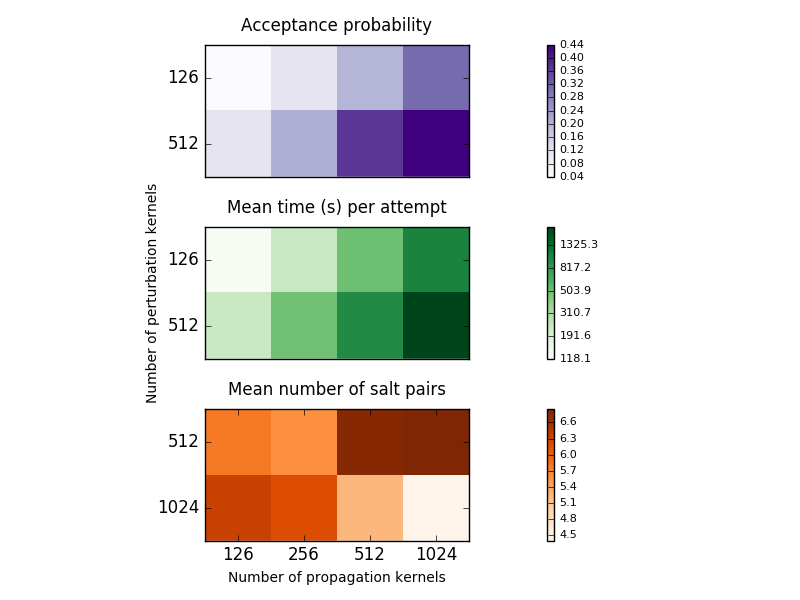

In [5]:
plt.clf()
fig,ax = plt.subplots(nrows=3,ncols=1,squeeze=True)

# Acceptance probability
cax = ax[0].matshow(np.round(AccProb2,2),cmap=plt.cm.Purples,interpolation='none')
c = fig.colorbar(cax,ax=ax[0])
c.ax.tick_params(labelsize=8) 
ax[0].get_xaxis().set_visible(False)
ax[0].set_yticklabels(['']+nperturbations)
ax[0].set_title('Acceptance probability',fontsize=12)

# Mean time per attempt on log scale
logtimes = np.log10(MeanTime2)
lt = np.arange(np.min(logtimes),np.max(logtimes),0.21)
ticks = np.round(10**lt,1)
cax = ax[1].matshow(logtimes,cmap=plt.cm.Greens,interpolation='none')
c = fig.colorbar(cax,ticks=lt,ax=ax[1])
c.set_ticklabels(ticks, update_ticks=True)
c.ax.tick_params(labelsize=8) 
ax[1].get_xaxis().set_visible(False)
#ax[1].xaxis.set_tick_params(labelbottom='on',labeltop='off')
ax[1].set_yticklabels(['']+nperturbations)
ax[1].set_title('Mean time (s) per attempt',fontsize=12)
ax[1].set_ylabel("Number of perturbation kernels",fontsize=10)   

# Mean number of salt pairs to test consistency
cax = ax[2].matshow(MeanSalt2,cmap=plt.cm.Oranges,interpolation='none')
c = fig.colorbar(cax)
c.ax.tick_params(labelsize=8) 
ax[2].set_xticklabels(['']+npropogations2)
ax[2].xaxis.set_tick_params(labelbottom='on',labeltop='off')
ax[2].set_yticklabels(['']+nperturbations2)
ax[2].set_title('Mean number of salt pairs',fontsize=12)
ax[2].set_xlabel("Number of propagation kernels",fontsize=10)    
ax[2].xaxis.set_label_position('bottom') 
#(h_pad=-1,w_pad=-100)
plt.tight_layout(h_pad=-1,rect=(-1,0,1,1)) # rect = (left, bottom, right, top)
plt.savefig("ParamSweep2.png", format='png')
Image("ParamSweep2.png",width=1200)

The apparanent drop in the mean number of salt pairs at 1024 propagation kernels and 1024 perturbations is due the high variance from too few samples---the job did not complete before it was kicked off the queue.

<a id='good_params'></a>
# 'Best' NCMC parameters

Trying to find the best compromise between computational speed and acceptance probability/statistical efficiency.

In [6]:
pairs = list((x,y) for x in nperturbations for y in npropogations) + list((x,y) for x in nperturbations2 for y in npropogations2)
#pairs = list((x,y) for x in nperturbations for y in npropogations)
#pairs = pairs + [(512,126),(512,256),(512,512),(512,1024)] + [(1024,126),(1024,256),(1024,512),(1024,1024)]

mean_time = []
stat_inefficiency = []
acc_prob = []
effsamples = []   # The effective number of samples
protocols = []
for pair in pairs:
    # Reading in data
    filename = 'NCMC_sweep_GHMC/nk{0}_nV{1}/run1.txt'.format(pair[0],pair[1])
    data = readdata(filename) # nwats, nsalt, prob, time
    # Discarding the unconverged data
    if data[1].mean() > 3:
        stineff = ts.statisticalInefficiency(data[1])
        stat_inefficiency.append(stineff)
        effsamples.append(len(data[1])/stineff)
        mean_time.append(data[3].mean()/10)
        acc_prob.append(data[2][-1])
        protocols.append(pair)
        
effsamples = np.array(effsamples)
stat_inefficiency = np.array(stat_inefficiency)
acc_prob = np.array(acc_prob)
mean_time = np.array(mean_time)

Plotting the comprimise between compute time of NCMC protocol and acceptance probability and statistical efficiency.

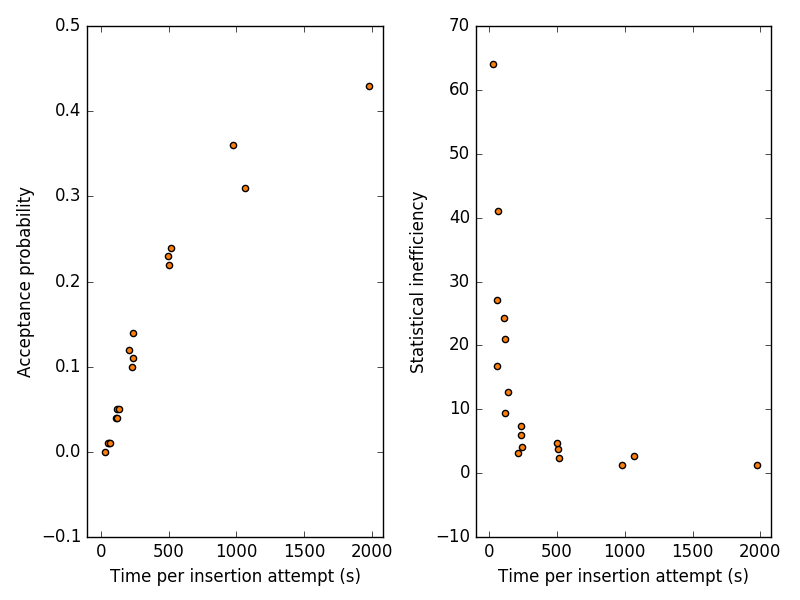

In [7]:
plt.clf()
f, axarr = plt.subplots(1, 2)
axarr[0].scatter(mean_time,acc_prob,color=tableau4[3],edgecolors='k')
axarr[0].set_xlim((-100,mean_time.max()+100))
axarr[0].set_xlabel('Time per insertion attempt (s)')
axarr[0].set_ylabel('Acceptance probability')

axarr[1].scatter(mean_time,stat_inefficiency,color=tableau4[3],edgecolors='k')
axarr[1].set_xlim((-100,mean_time.max()+100))
axarr[1].set_xlabel('Time per insertion attempt (s)')
axarr[1].set_ylabel('Statistical inefficiency')

plt.tight_layout()
plt.savefig("NCMC_timings.png", format='png')
Image("NCMC_timings.png")


<a id='stat_ineff'></a>
### Focusing on statistical inefficiency 
Looking at the protocols with low statistical inefficiency:

In [8]:
print '        Protocol         | stat. ineff.'
print'----------------------------------------'
for e,p in zip(stat_inefficiency,protocols):
    if e < 5:
        print ' {0:4} pert. | {1:4} prop. |     {2:2}'.format(p[0],p[1],round(e,1))
print'----------------------------------------'
           

        Protocol         | stat. ineff.
----------------------------------------
 2048 pert. |   64 prop. |     3.2
 4096 pert. |   32 prop. |     4.1
 4096 pert. |   64 prop. |     2.4
  512 pert. |  512 prop. |     3.8
  512 pert. | 1024 prop. |     2.6
 1024 pert. |  256 prop. |     4.7
 1024 pert. |  512 prop. |     1.3
 1024 pert. | 1024 prop. |     1.3
----------------------------------------


Viewing some of the trajectories by eye, and marking where 'equilibrium' has been detected.

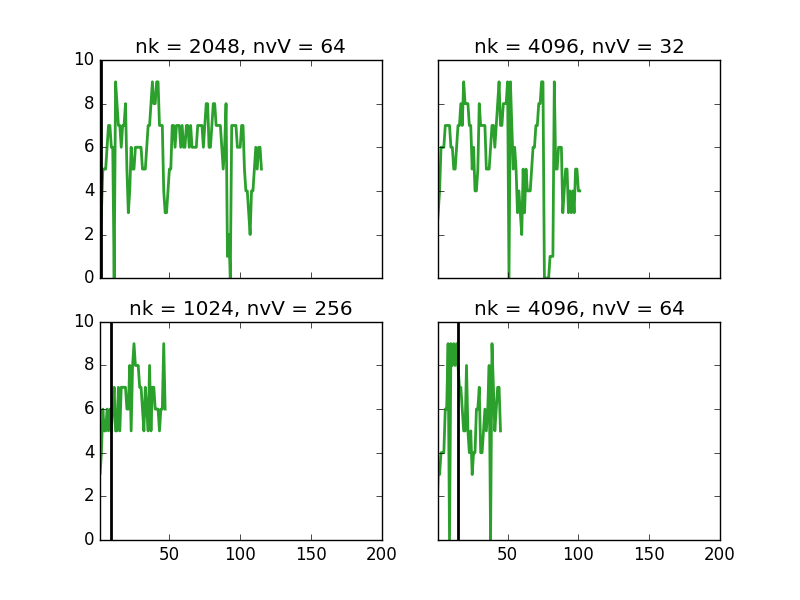

In [9]:
params = [(2048,64),(4096,32),(1024,256),(4096,64)]
coords = [(0,0),(0,1),(1,0),(1,1)]

f, axarr = plt.subplots(2, 2)
xlims =(1,200)       # x limits
ylims = (0,10)       # y limits


for p,c in zip(params,coords):
    # Reading in data
    filename = 'NCMC_sweep_GHMC/nk{0}_nV{1}/run1.txt'.format(p[0],p[1])
    nsalt = readdata(filename)[1]
    #time = np.arange(1,len(nsalt)+1) 
    time = range(len(nsalt))
    # Plotting
    axarr[c].plot(nsalt,color=tableau4[1],linewidth=2)
    axarr[c].set_xlim(xlims)
    axarr[c].set_ylim(ylims)
    axarr[c].set_ylim(ylims)
    axarr[c].set_title('nk = {0}, nvV = {1}'.format(p[0],p[1]))
    try:
        stats = ts.detectEquilibration(nsalt) # Start of equil time, stat inefficiency, num uncorrelated sample
        axarr[c].axvline(x=stats[0],linewidth=2, color='k')
    except ts.ParameterError:
        pass
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)  

plt.savefig("TimeSeries.png", format='png')
Image("TimeSeries.png")

<a id='eff_samps'></a>
### Effective number of sample
Seeing which protocol maximises the number of uncorrelated samples in for a fixed wall time. The wall-time was set to 70 hours, and many of the best protocols did not finish within the alloted cluster walltime.

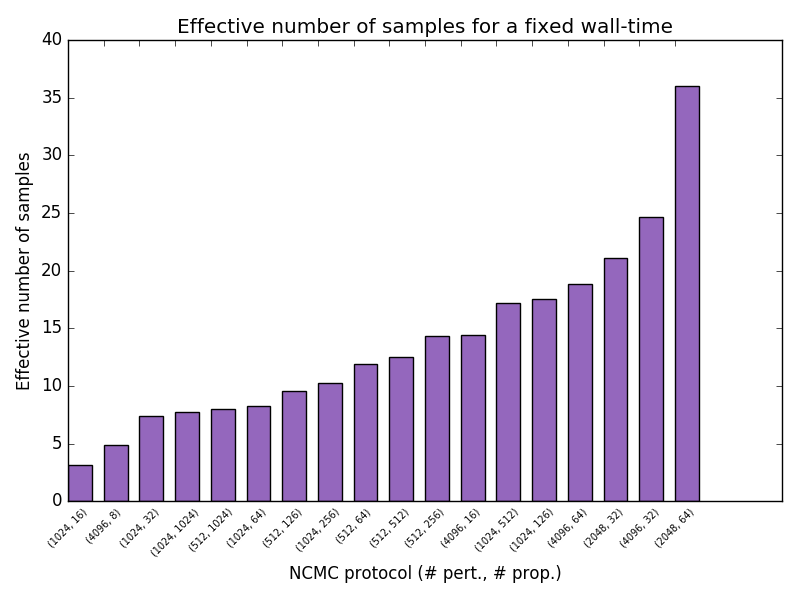

In [10]:
sort_prot = [x for (y,x) in sorted(zip(effsamples,protocols))]
sort_effsamp = sorted(effsamples)

ind = np.arange(len(sort_prot))*6  # the x locations for the groups

fig, ax = plt.subplots()
rects = ax.bar(ind, sort_effsamp, color=tableau4[2],width=4)
ax.set_xticks(ind)
ax.set_xticklabels(sort_prot,rotation=45,size='xx-small')
ax.set_ylabel('Effective number of samples')
ax.set_xlabel('NCMC protocol (# pert., # prop.)')
ax.set_title('Effective number of samples for a fixed wall-time')

plt.tight_layout()
plt.savefig("NumEffSamps.png", format='png')
Image("NumEffSamps.png")

High numbers of propogation steps do well at generating uncorrelated samples in a fixed wall-time. For instance, 2048 perturbation kernels with 64 propagation kernels produces a greater number of effective samples despite the fact that 4096 kernels with 32 or 64 propagation kernels has at least as many energy evaluations.

<a id='acc_prob'></a>
### Focusing on maximising acceptance probability
Based on the above, I'll make a selection of what I think are good comprimises between speed and good sampling. Throwing away any protocol that has an acceptance probability of less than 10% and a time greater than 1000 seconds.

In [11]:
# Ordering with respect to run-time
prots = [x for (y,x) in sorted(zip(mean_time,protocols))]
acc = [x for (y,x) in sorted(zip(mean_time,acc_prob))]
times = sorted(mean_time)

print ' # pert. | # prop. steps | acc. prob. |  time (s)'
print '-------------------------------------------------'
for p,a,t in zip(prots,acc,times):
    if a >=0.1 and t <1000:
        #print '# pert. = {0}, # props. = {1}, with acceptance probability {2} and time {3}s'.format(p[0],p[1],a,round(t))
        print ' {0:4}           {1:3}           {2:4}       {3:3}  '.format(p[0],p[1],a,round(t))
print '-------------------------------------------------'


 # pert. | # prop. steps | acc. prob. |  time (s)
-------------------------------------------------
 2048            64           0.12       210.0  
  512           256            0.1       231.0  
 1024           126           0.11       233.0  
 4096            32           0.14       240.0  
 1024           256           0.23       498.0  
  512           512           0.22       505.0  
 4096            64           0.24       514.0  
 1024           512           0.36       977.0  
-------------------------------------------------


There appear to be 2 time regimes that are most useful: around 200 seconds and around 500 seconds. Protocols # pert. = 4096 with # prop. = 32 and # pert. = 2048 with # prop. = 64 seem to be a good compromise between time and acceptance probability, as well as effective number of samples. This suggests I should investigate protocols with more perturbations but fewer steps. For instance:

| # perturbations | # propagtions|
|:-------:|:-------:|
|8064   |16|
|16128  |8|
|64512  |2|
|129024 |1|

Or tring to reduce the compute time with these protocols:

| # perturbations | # propagtions|
|:-------:|:-------:|
|8064  |8|
|16128  |4|
|32256  |2|
|64512  |1|


## Work distributions

To do...

## Acceptance probabilities of GHMC propagator
To do...